In [0]:
  """
@author: gagandeepbajwa
    based on sattelite-clustering.py by @franama

""" 
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_extraction.image import grid_to_graph
import cv2

#colab imorts
from google.colab import drive
from google.colab.patches import cv2_imshow # because cv2 doesnot work in colab

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

#defining gloab data
global_data=[]

'''
Function Description: Running heirarchical Clustering on the image

'''
def hierarchical_clustering(image, img, desired_clusters):

    print('Starting executing the heirarchical clustering')
    
      # set parameters for clustering
    n_clusters_desired = desired_clusters # need to experiment with this
    print('Going to run the heirarchical clustering')
    hierarchical_clustering = AgglomerativeClustering(n_clusters = None, distance_threshold=25.0, linkage='ward') #distance_threshold

    # do the clustering
    hierarchical_clustering.fit(image)

    # extract cluster labels and reshape for plotting
    X_cluster = hierarchical_clustering.labels_
    X_cluster = X_cluster.reshape(img[:, :, 0].shape)

    plt.figure(figsize=(7, 7))
    #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    # Create the colormap
    #cm = LinearSegmentedColormap.from_list("my map", colors, N=10)
    plt.imshow(X_cluster) #, cmap=cm)
    plt.colorbar()
    plt.show()

    # returning the following values: number of clusters, lables, number of trees in the hierarchical tree
    #           number of connected components in the graph
    return hierarchical_clustering.n_clusters, hierarchical_clustering.labels_, hierarchical_clustering.n_leaves_, hierarchical_clustering.n_connected_components_



'''
Function Description: Running the DBSCAN
'''
def dbscan_clustering(image, img):
    
    dbscan_clustering = DBSCAN(eps=0.5, min_samples=10, algorithm= 'ball_tree')

    dbscan_clustering.fit(image)

    X_cluster = dbscan_clustering.labels_
    X_cluster = X_cluster.reshape(img[:, :, 0].shape)

    plt.figure(figsize=(20, 20))
    #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    # Create the colormap
    #cm = LinearSegmentedColormap.from_list("my map", colors, N=10)
    plt.imshow(X_cluster) #, cmap=cm)
    plt.colorbar()
    plt.show()


'''
Function Description: Creating the colormap of the whole image by providing the cropped clustered data
'''    
def create_color_map(data, originalImageData, img, cropped_size):
  
    print('Starting creating the color map')

    #initializing the final_labels
    final_labels=data[0][1][:cropped_size]

    #   for d in range(len(data)-1):
    #     print(type(data[d+1][1]))
    #     print(len(data[d+1][1]))
    #     final_labels =np.concatenate((final_labels,data[d+1][1]))


    #for loop to copy the data appropiately
    csm = 0
    mastern = 0
#     for master in range(7):
#       mastern=0
#       for x in range(cropped_size):

#         for y in range(7):
#           final_labels = np.concatenate((final_labels, data[y+mastern+1][1][csm:csm+cropped_size]))

#           if(y==6):# when y i s6 change the csm to add 196 from each image
#             csm=csm+cropped_size

#         #changing the master number plus 7
        
#         mastern = mastern + 7


    #final_lables = final_labels.reshape(img[:, :, 0].shape)


    #saving the labels, original_cropped images and orginal_image
    global global_data
    global_data.append(img)
    global_data.append(originalImageData)
    global_data.append(final_labels)
    global_data.append(data)

    print('Original Image shape ',img[:, :, 0].shape)
    print('Final Labels ', final_labels.shape)

#     plt.figure(figsize=(20,20))

#     plt.imshow(final_labels)
#     plt.colorbar()
#     plt.show()
  
  




'''
Function Description: Splitting the main image
'''
def image_splitter(image, number):
    
    print('Starting the image splitting')
    #showing the original image
    #img=cv2.imread(image)
    img= image;
    #cv2.imshow('output', img) does not work witj colab
   # cv2_imshow(img)
    #cv2.waitKey(0)

    #Getting the size of the image
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    #Size per cropped image
    cropped_size = int(img.shape[0]/number) # as we have square images, this need to be changed according to the image dimensions
 
    # intitializing the array to store all the required information
    data = [];
    
    #initializing the array that will store numpy array objects of the cropped images
    original_data=[]

    #crop starter
    cs = 0
    cj_cs=0
    cj=0
    for i in range(2):
      
        cj=cj_cs
        cj_cs=cj_cs+cropped_size
        
        print('Y star reached ' ,cj)
        
        print('Y end reached ',cj_cs)
        
        #starting again from the left most
        cs=0
        
        for j in range(2):
          
            print('X start reached ', cs)
            
            print('X end reached ', cs+cropped_size)
          
            #cropping down the image
            crop_img = img[ cj:cj_cs,cs:cs+cropped_size ]

            #informative
            print('Number of rows in the cropped image: ',crop_img.shape[0])
            print('Numebr of columns in the cropped image: ', crop_img.shape[1])
            print('Number of bands in the cropped image: ', crop_img.shape[2])


            #initialize an empty numpy array of cropped image size
            np_crop_img =  np.zeros((crop_img.shape[0],  # number of rows
                            crop_img.shape[1],  # number of cols
                            crop_img.shape[2])  # number of bands
                            )


            #store the image data in the numpy array for reshaping
            for b in range(crop_img.shape[2]):
                np_crop_img[:,:,b] = crop_img[:,:,b]   

            #convert the image to single to numpy array
            new_crop_img_shape = (np_crop_img.shape[0]*np_crop_img.shape[1], np_crop_img.shape[2])
            crop_img_X = np_crop_img[:,:,:np_crop_img.shape[2]].reshape(new_crop_img_shape)
            print(crop_img_X.shape)
                        
            #before running heirarchical clustering find the number of appropriate clusters in the cropped image
            ap_clusters_possible=elbow_method(crop_img_X, 7) #7 is the maximum number of clusters found in the whole image using elbow method

            # showing the cropped image
            #before showing the cropped image we only need 3 bands
            clr_cropped_img = np.zeros((crop_img.shape[0], crop_img.shape[1], 3))
            for b in range(1,4):
              clr_cropped_img[:, :, 3-b] = crop_img[:, :, b]
            
            #display the image
            plt.figure(figsize=(5, 5))
            plt.imshow(clr_cropped_img)
        
            #cv2_imshow(crop_img)

            #Runninng hierarchical clustering on the cropped image and  receiving the 
            (n_cluster, lables, n_leaves, n_connected_components )=hierarchical_clustering(crop_img_X, crop_img,ap_clusters_possible )

            #pushing the cropped image numpy array to the image_data array
            original_data.append(crop_img)

            #pushing the data to the data array for further interpretation
            data.append((n_cluster, lables, n_leaves, n_connected_components ))

            print('Number of clusters found: ', n_cluster)
            print('Labels: ', lables)
            print('Number of leaves: ', n_leaves)
            print('Number of connected components: ', n_connected_components )



            #increment the crop starter
            cs=cs+cropped_size

            #show the cropped image
            #cv2.imshow("its cropped",crop_img)
            #cv2.waitKey(0)
    

    #printing totla number of clustered cities we get
    print('Total number of different clustered cropped images we got: ', len(data))
    
    #create the color map
    create_color_map(data, original_data, img, cropped_size)




"""
Plots number of clusters vs. within cluster sum of squares
(which we aim to minimize)
"""


def elbow_method(image_2d, max_k):
    wcss = []
    for i in range(2, max_k):
        kmeans = KMeans(n_clusters=i, init='k-means++',
                        random_state=42)
        kmeans.fit(image_2d)
        wcss.append(kmeans.inertia_)

    x = [i for i in range(2, max_k)]
    plt.plot(x, wcss, '--bo')
    plt.xticks(x, x)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    #after plotting the elbow find the corner point
    



'''
Function Description: Display an image
'''



'''
Function Description: Main Function
'''

if __name__ == "__main__":
    

    drive.mount('/content/gdrive')
    # parse command line arg
    try:
        #!cp '/content/gdrive/My Drive/2019-10-2-111855.png' image
        image = '/content/gdrive/My Drive/sentinel2.bin'   #trying it with the 12 band original image

    # catch no file given
    except IndexError:
        print("Must provide a filename")
        sys.exit(0)

    #with the same image create multiple images
    


    # Read in raster image
    img_ds = gdal.Open(image, gdal.GA_ReadOnly)



    # allocate memory to reshape image
    img = np.zeros((img_ds.RasterYSize,  # number of rows
                    img_ds.RasterXSize,  # number of cols
                    img_ds.RasterCount),  # number of bands
                    gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType)) # data type code

    # reshape the image band by band
    for b in range(img.shape[2]):
        print("reading band", b + 1, "of", img.shape[2])
        print('Band Type: ', img_ds.GetRasterBand(b+1).DataType)
        img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
        print('Max value in band', b,' is ', np.amax(img[:,:,b]))

    #Printing the shape of the image
    print(img.shape[0]*img.shape[1])
    print('Image Raster Count: ', img.shape[2])


    #Downsampling the image before reshaping
   #img = img[::2, ::2] + img[1::2, ::2] + img[::2, 1::2] + img[1::2, 1::2]

    # reshape image again to match expected format for scikit-learn
    new_shape = (img.shape[0] * img.shape[1], img.shape[2])
    X = img[:, :, :img.shape[2]].reshape(new_shape)
    print (X.shape[0])

    
    new_img = img[0:392,0:392]
    #running the hierarchical clustering
    #hierarchical_clustering(X, img, 7)

    #runnig the DBSCAN
    #dbscan_clustering(X, img)

    #running image splitting
    #image_splitter(image, 7)
    #image_splitter(img,7)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
reading band 1 of 12
Band Type:  6
Max value in band 0  is  1.0
reading band 2 of 12
Band Type:  6
Max value in band 1  is  1.0
reading band 3 of 12
Band Type:  6
Max value in band 2  is  1.0
reading band 4 of 12
Band Type:  6
Max value in band 3  is  1.0
reading band 5 of 12
Band Type:  6
Max value in band 4  is  1.0
reading band 6 of 12
Band Type:  6
Max value in band 5  is  1.0
reading band 7 of 12
Band Type:  6
Max value in band 6  is  1.0
reading band 8 of 12
Band Type:  6
Max value in band 7  is  1.0
reading band 9 of 12
Band Type:  6
Max value in band 8  is  1.0
reading band 10 of 12
Band Type:  6
Max value in band 9  is  1.0
reading band 11 of 12
Band Type:  6
Max value in band 10  is  1.0
reading band 12 of 12
Band Type:  6
Max value in band 11  is  1.0
1882384
Image Raster Count:  12
1882384


In [0]:


import GPUtil
GPUtil.showUtilization(all=True)

| ID | Name      | Serial        | UUID                                     || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  0 | Tesla K80 | 0324514079413 | GPU-e6092f49-1c11-e5ee-bdcd-c08e42dada9e ||       58C |        0% |           0% ||      11441MB |         0MB |     11441MB || Disabled     | Disabled       |


Ways to compare the clsuters

-- take centroid of clusters
-- random sampling


Important to note here is that cv2.imshow() is disabled in Colab, because it causes Jupyter sessions. So as the substitution consider user 'from google.colab.patches import cv2_imshow'

In [0]:
#array to store all the cluster objects
clusters =[]

#show the final colored image
image = global_data[0]

cropped_images = global_data[1]

final_labels_ = global_data[2]

data = global_data[3]


final_labels = [] #List containing the final 


print("data length: ", len(data))



print('Cropped_Images shape:   ', cropped_images[0].shape)



cluster_nos =[]
indexes_for_clusters=[]
labels_in_cropped =[] #storing labels in the cropped image shape, so it will be easy to join them at the end

#comparing the cluster objects and deciding whether two cluster objects need to be considered one or not
for r in range(len(data)): # go through all the elements stored in the data object
  labels = data[r][1] # getting labels for individual cropped images
  #reshaping the labels into the cropped image shape
  labels_cr = labels.reshape(cropped_images[0][ :, :, 0].shape)
  #labels_cr = labels #just here for testing
  labels_in_cropped.append(labels_cr)
  cluster_nos.append(max(labels)) # appending the maximum number in labels means number of clusters in that cropped_image
  for k in range(max(labels)+1): # go through each of the cluster
    np_labels = np.array(labels_cr)
    indexes_f = np.where(np_labels==k) # get all the indexes of the occurrence of specific element in the numpy array
    i_cluster_values_ = []
    indexes = np.array((indexes_f[0], indexes_f[1])).T
    print(indexes)
    
    for ind in range(len(indexes)):
      i_cluster_values_.append(cropped_images[r][indexes[ind][0], indexes[ind][1]])
   # i_cluster_values=cropped_images[r][indexes] # get all the values at the specific indexes
    #i_cluster_values = np.take(cropped_images[r], indexes)
    i_cluster_values = np.array(i_cluster_values_) #.reshape(cropped_images[0].shape[0]*cropped_images[0].shape[1], cropped_images[0].shape[2])
    print('cluster_vlaue we got: ', i_cluster_values.shape)
    clusters.append([i_cluster_values, 0]) # append all the cluster objects to the clusters list
    indexes_for_clusters.append([indexes, r, k]) # appending all the clusters's index and indexes of all the objects in that cluster we got from running heirarchical clustering on a cropped image
  
  

#printing total number of cluster objects we found
print("Total Number of clusters found: ",len(clusters))
print("Maximum number of clusters found in the cropped images: ", max(cluster_nos))
print(len(clusters[0][0]))

#labels numbers user
lnu = []

#compared
comparedp = 0

magic_number = []

for i in range(len(clusters)):
  magic_number.append(i)
  



#starting comparing the clusters
for a in range(len(clusters)):
  comparedp = 0 # re-initilaizae it toi zero for each cluster a 
  for b in range(a,len(clusters)):
    if(a!=b and clusters[a][1] != 1 and clusters[b][1]!=1): # processed with the comparison only if both clusters are different
      cluster_a = clusters[a][0]
      cluster_b = clusters[b][0]
      a_b = np.concatenate((cluster_a, cluster_b))
      #now run the heirarchical clustering
      hierarchical_clustering = AgglomerativeClustering(n_clusters = None, distance_threshold=27.0, linkage='ward')  #distance threshold has been changed from 25 to 30, need to experiment with it

      # do the clustering
      hierarchical_clustering.fit(a_b)
             
      # extract cluster labels and reshape for plotting
      cluster = hierarchical_clustering.labels_
      #printing total number of clusters found
      #print(max(cluster))
      if(max(cluster)>=1):
        print('Move on, they are different clusters', a, 'and ', b)
        
        #update the label numbers, because their label number may be acquired by some other clusters while merging, do this only when your cluster is unique
        if(b==magic_number[len(magic_number)-1] and comparedp==0):
            print('Cluster Number: ',a,' came out to be a lonely cluster')
          
            cropped_imgan = indexes_for_clusters[a][1]
            indexes_vtca = indexes_for_clusters[a][0]
            values1=[]
            for values in indexes_vtca:
              if(len(lnu)==0):
                values1.append(0)
             
              else:
                values1.append(lnu[len(lnu)-1]+1)
            
            indlablesa = indexes_vtca
            for inla in range(len(indexes_vtca)):
              labels_in_cropped[cropped_imgan][indlablesa[inla][0], indlablesa[inla][1]] = values1[inla]
            
            
            lnu.append(lnu[len(lnu)-1]+1) # this label number is already used
            print(lnu)
          
         
        
      else:
          #increment the compared positive
          comparedp+=1
          magic_number.remove(b) #add removed clusters to the magic_number list
          print('Magic Numeber: ', magic_number) #informative print
          clusters[b][1]= 1 #mark the cluster as done because we dont need to compare it with other clusters again
          print('Something is here to think about')
          indexes_vtca = indexes_for_clusters[a][0] # indexes where values need to be changed
          cropped_imgan = indexes_for_clusters[a][1]

          indexes_vtcb = indexes_for_clusters[b][0] # indexes where values need to be changed
          cropped_imgbn = indexes_for_clusters[b][1]
    
          
          values2a=[]
          for values in indexes_vtca:
             if(len(lnu)==0):
              values2a.append(0)
             
             else:
                if(comparedp>1):
                  values2a.append(lnu[len(lnu)-1])
                
                else:
                  values2a.append(lnu[len(lnu)-1]+1)
             
          
          values2b=[]
          for values in indexes_vtcb:
            if(len(lnu)==0):
              values2b.append(0)
            
            else:
              if(comparedp>1):
                values2b.append(lnu[len(lnu)-1])
              
              else:
                values2b.append(lnu[len(lnu)-1]+1)
          
          indlablesa = indexes_vtca
          indlablesb = indexes_vtcb
          for inla in range(len(indexes_vtca)):
            labels_in_cropped[cropped_imgan][indlablesa[inla][0], indlablesa[inla][1]] = values2a[inla]
          
          for inlb in range(len(indexes_vtcb)):
            labels_in_cropped[cropped_imgbn][indlablesb[inlb][0], indlablesb[inlb][1]] = values2b[inlb]
 
          if(comparedp==1):
            lnu.append(values2a[0]) # this label number is already used
          
          print(lnu)
         
        
        
      
      
#       plt.figure(figsize=(7, 7))
#       #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
#       # Create the colormap
#       #cm = LinearSegmentedColormap.from_list("my map", colors, N=10)
#       plt.imshow(X_cluster) #, cmap=cm)
#       plt.colorbar()
#       plt.show()
            

#join the cropped labels
print('------------------------\nStarting Joining the Cropped Images\n----------------- ')
#cropped Size
cropped_size = 196

csm = 0
mastern = 0

print('labels_in_cropped size: ', len(labels_in_cropped))


print('Number of clusters found in the result image: ', len(lnu))


for master in range(2):
#     print('Mastern Value is: ', mastern)
    #after the new row is started initialize csm back to 0
    csm=0
    for x in range(cropped_size):
#         print('x is: ', x)       
        for y in range(2):
#           print('csm value is: ', csm)
#           print("csm plus cropped size: ", csm + cropped_size)   
            #showing the cropped image with the new labels
#           plt.figure(figsize=(5,5))
#           plt.imshow(labels_in_cropped[y+mastern].reshape(196,196))
      
          #doing the appending operations
          data_= labels_in_cropped[y+mastern].reshape(cropped_size*cropped_size)  
          final_labels = np.concatenate((final_labels, data_[csm:csm+cropped_size]))
          #size of the final labels
#           print(final_labels.shape)
          
          if(y==1):# when y i s6 change the csm to add 196 from each image
            csm=csm+cropped_size
        
        if(x==195):
          #changing the master number plus 7     
          mastern = mastern + 2  
  
  
  
  
print(image.shape)
print(final_labels.shape)  
  
#reshaping the final labels
rfl = final_labels.reshape(392,392)

print(rfl.shape)  
  
print('Number of clusters found in the final image', max(final_labels)+1)

# allocate memory to reshape image
img_colored = np.zeros((392,  # number of rows
                392,  # number of cols
                3),  # number of bands
                gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType)) # data type code
  

for b in range(1,4):
  img_colored[:, :, 3-b] = img[0:392, 0:392, b]

  
  


plt.figure(figsize=(10, 10))
plt.imshow(img_colored) #show the colored image for the testing image of size 392, 392

plt.savefig('/content/gdrive/My Drive/cropped_img.png')
# drive.download('cropped_image.png')
  
#shwing the final image
plt.figure(figsize=(10, 10))
plt.imshow(rfl)
#plt.colorbar() 
plt.savefig('/content/gdrive/My Drive/color_map.png')







data length:  4
Cropped_Images shape:    (196, 196, 12)
[[  0   5]
 [  0   9]
 [  0  10]
 ...
 [195 187]
 [195 194]
 [195 195]]
cluster_vlaue we got:  (19282, 12)
[[  0  27]
 [  0  28]
 [  0  29]
 ...
 [195 171]
 [195 172]
 [195 173]]
cluster_vlaue we got:  (1792, 12)
[[  0   6]
 [  0   7]
 [  0   8]
 ...
 [195 191]
 [195 192]
 [195 193]]
cluster_vlaue we got:  (8223, 12)
[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [195 179]
 [195 180]
 [195 184]]
cluster_vlaue we got:  (9119, 12)
[[  0  13]
 [  0  14]
 [  0  16]
 ...
 [195 182]
 [195 183]
 [195 184]]
cluster_vlaue we got:  (6358, 12)
[[  0  15]
 [  0  22]
 [  0  25]
 ...
 [195 186]
 [195 192]
 [195 193]]
cluster_vlaue we got:  (12970, 12)
[[  0  54]
 [  0 142]
 [  0 143]
 ...
 [195  76]
 [195  77]
 [195  78]]
cluster_vlaue we got:  (5224, 12)
[[  0  17]
 [  0  18]
 [  0  19]
 [  3  23]
 [  4  22]
 [  4  23]
 [  6  27]
 [  7  27]
 [ 31  60]
 [ 33  61]
 [ 34  61]
 [ 49  30]
 [101 147]
 [101 148]
 [101 149]
 [102 147]
 [102 148]
 [102 149]
 [

In [0]:
'''
Description: Run Heirarchical Clustering and merging clustering using random sampling of data points from different clustering
'''
#array to store all the cluster objects
clusters =[]

#show the final colored image
image = global_data[0]

cropped_images = global_data[1]

final_labels_ = global_data[2]

data = global_data[3]


final_labels = [] #List containing the final 


print("data length: ", len(data))



print('Cropped_Images shape:   ', cropped_images[0].shape)



cluster_nos =[]
indexes_for_clusters=[]
labels_in_cropped =[] #storing labels in the cropped image shape, so it will be easy to join them at the end

#comparing the cluster objects and deciding whether two cluster objects need to be considered one or not
for r in range(len(data)): # go through all the elements stored in the data object
  labels = data[r][1] # getting labels for individual cropped images
  #reshaping the labels into the cropped image shape
  labels_cr = labels.reshape(cropped_images[0][ :, :, 0].shape)
  #labels_cr = labels #just here for testing
  labels_in_cropped.append(labels_cr)
  cluster_nos.append(max(labels)) # appending the maximum number in labels means number of clusters in that cropped_image
  for k in range(max(labels)+1): # go through each of the cluster
    np_labels = np.array(labels_cr)
    indexes_f = np.where(np_labels==k) # get all the indexes of the occurrence of specific element in the numpy array
    i_cluster_values_ = []
    indexes = np.array((indexes_f[0], indexes_f[1])).T
    print(indexes)
    
    for ind in range(len(indexes)):
      i_cluster_values_.append(cropped_images[r][indexes[ind][0], indexes[ind][1]])
   # i_cluster_values=cropped_images[r][indexes] # get all the values at the specific indexes
    #i_cluster_values = np.take(cropped_images[r], indexes)
    i_cluster_values = np.array(i_cluster_values_) #.reshape(cropped_images[0].shape[0]*cropped_images[0].shape[1], cropped_images[0].shape[2])
    print('cluster_vlaue we got: ', i_cluster_values.shape)
    clusters.append([i_cluster_values, 0]) # append all the cluster objects to the clusters list
    indexes_for_clusters.append([indexes, r, k]) # appending all the clusters's index and indexes of all the objects in that cluster we got from running heirarchical clustering on a cropped image
  
  

#printing total number of cluster objects we found
print("Total Number of clusters found: ",len(clusters))
print("Maximum number of clusters found in the cropped images: ", max(cluster_nos))
print(len(clusters[0][0]))

#labels numbers user
lnu = []

#compared
comparedp = 0

magic_number = []

for i in range(len(clusters)):
  magic_number.append(i)
  



#starting comparing the clusters
for a in range(len(clusters)):
  comparedp = 0 # re-initilaizae it to zero for each cluster a 
  cluster_a = clusters[a][0]
  for b in range(a,len(clusters)):
    if(a!=b and clusters[a][1] != 1 and clusters[b][1]!=1): # processed with the comparison only if both clusters are different
      #cluster_a = clusters[a][0]
      cluster_b = clusters[b][0]
      
      
      #do random sampling of the data points of differnet clusters, taking 10% of random data points
      rs_cluster_a = cluster_a[np.random.choice(cluster_a.shape[0], int((cluster_a.shape[0]/10)*2), replace=False)]
      rs_cluster_b = cluster_b[np.random.choice(cluster_b.shape[0], int((cluster_b.shape[0]/10)*2), replace=False)]
      print(rs_cluster_a.shape, '      ', rs_cluster_b.shape)

      print('From CLuster', a,' Took: ', rs_cluster_a.shape[0], ' datapoints from total ',cluster_a.shape[0]  )
      print('From CLuster', b,' Took: ', rs_cluster_b.shape[0], ' datapoints from total ',cluster_b.shape[0]  )
      
      a_b = np.concatenate((rs_cluster_a, rs_cluster_b))
      #now run the heirarchical clustering
      hierarchical_clustering = AgglomerativeClustering(n_clusters = None, distance_threshold=27.0, linkage='ward')  #distance threshold has been changed from 25 to 30, need to experiment with it

      # do the clustering
      hierarchical_clustering.fit(a_b)
             
      # extract cluster labels and reshape for plotting
      cluster = hierarchical_clustering.labels_
      #printing total number of clusters found
      #print(max(cluster))
      if(max(cluster)>=1):
        print('Move on, they are different clusters', a, 'and ', b)
        
        #update the label numbers, because their label number may be acquired by some other clusters while merging, do this only when your cluster is unique
        if(b==magic_number[len(magic_number)-1] and comparedp==0):
            print('Cluster Number: ',a,' came out to be a lonely cluster')
          
            cropped_imgan = indexes_for_clusters[a][1]
            indexes_vtca = indexes_for_clusters[a][0]
            values1=[]
            for values in indexes_vtca:
              if(len(lnu)==0):
                values1.append(0)
             
              else:
                values1.append(lnu[len(lnu)-1]+1)
            
            indlablesa = indexes_vtca
            for inla in range(len(indexes_vtca)):
              labels_in_cropped[cropped_imgan][indlablesa[inla][0], indlablesa[inla][1]] = values1[inla]
            
            
            lnu.append(lnu[len(lnu)-1]+1) # this label number is already used
            print(lnu)
          
         
        
      else:
          #increment the compared positive
          comparedp+=1
          magic_number.remove(b) #add removed clusters to the magic_number list
          print('Magic Numeber: ', magic_number) #informative print
          clusters[b][1]= 1 #mark the cluster as done because we dont need to compare it with other clusters again
          print('Something is here to think about')
          indexes_vtca = indexes_for_clusters[a][0] # indexes where values need to be changed
          cropped_imgan = indexes_for_clusters[a][1]

          indexes_vtcb = indexes_for_clusters[b][0] # indexes where values need to be changed
          cropped_imgbn = indexes_for_clusters[b][1]
    
          
          values2a=[]
          for values in indexes_vtca:
             if(len(lnu)==0):
              values2a.append(0)
             
             else:
                if(comparedp>1):
                  values2a.append(lnu[len(lnu)-1])
                
                else:
                  values2a.append(lnu[len(lnu)-1]+1)
             
          
          values2b=[]
          for values in indexes_vtcb:
            if(len(lnu)==0):
              values2b.append(0)
            
            else:
              if(comparedp>1):
                values2b.append(lnu[len(lnu)-1])
              
              else:
                values2b.append(lnu[len(lnu)-1]+1)
          
          indlablesa = indexes_vtca
          indlablesb = indexes_vtcb
          for inla in range(len(indexes_vtca)):
            labels_in_cropped[cropped_imgan][indlablesa[inla][0], indlablesa[inla][1]] = values2a[inla]
          
          for inlb in range(len(indexes_vtcb)):
            labels_in_cropped[cropped_imgbn][indlablesb[inlb][0], indlablesb[inlb][1]] = values2b[inlb]
 
          if(comparedp==1):
            lnu.append(values2a[0]) # this label number is already used
          
          print(lnu)
         
        
        
      
      
#       plt.figure(figsize=(7, 7))
#       #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
#       # Create the colormap
#       #cm = LinearSegmentedColormap.from_list("my map", colors, N=10)
#       plt.imshow(X_cluster) #, cmap=cm)
#       plt.colorbar()
#       plt.show()
            

#join the cropped labels
print('------------------------\nStarting Joining the Cropped Images\n----------------- ')
#cropped Size
cropped_size = 196

csm = 0
mastern = 0

print('labels_in_cropped size: ', len(labels_in_cropped))


print('Number of clusters found in the result image: ', len(lnu))


for master in range(2):
#     print('Mastern Value is: ', mastern)
    #after the new row is started initialize csm back to 0
    csm=0
    for x in range(cropped_size):
#         print('x is: ', x)       
        for y in range(2):
#           print('csm value is: ', csm)
#           print("csm plus cropped size: ", csm + cropped_size)   
            #showing the cropped image with the new labels
#           plt.figure(figsize=(5,5))
#           plt.imshow(labels_in_cropped[y+mastern].reshape(196,196))
      
          #doing the appending operations
          data_= labels_in_cropped[y+mastern].reshape(cropped_size*cropped_size)  
          final_labels = np.concatenate((final_labels, data_[csm:csm+cropped_size]))
          #size of the final labels
#           print(final_labels.shape)
          
          if(y==1):# when y i s6 change the csm to add 196 from each image
            csm=csm+cropped_size
        
        if(x==195):
          #changing the master number plus 7     
          mastern = mastern + 2  
  
  
  
  
print(image.shape)
print(final_labels.shape)  
  
#reshaping the final labels
rfl = final_labels.reshape(392,392)

print(rfl.shape)  
  
print('Number of clusters found in the final image', max(final_labels)+1)

# allocate memory to reshape image
img_colored = np.zeros((392,  # number of rows
                392,  # number of cols
                3),  # number of bands
                gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType)) # data type code
  

for b in range(1,4):
  img_colored[:, :, 3-b] = img[0:392, 0:392, b]

  
  


plt.figure(figsize=(10, 10))
plt.imshow(img_colored) #show the colored image for the testing image of size 392, 392

plt.savefig('/content/gdrive/My Drive/randomly_sampled/cropped_img_20%.png')
# drive.download('cropped_image.png')
  
#shwing the final image
plt.figure(figsize=(10, 10))
plt.imshow(rfl)
#plt.colorbar() 
plt.savefig('/content/gdrive/My Drive/randomly_sampled/color_map_20%.png')

data length:  4
Cropped_Images shape:    (196, 196, 12)
[[  0   5]
 [  0   9]
 [  0  10]
 ...
 [195 187]
 [195 194]
 [195 195]]
cluster_vlaue we got:  (19282, 12)
[[  0  27]
 [  0  28]
 [  0  29]
 ...
 [195 171]
 [195 172]
 [195 173]]
cluster_vlaue we got:  (1792, 12)
[[  0   6]
 [  0   7]
 [  0   8]
 ...
 [195 191]
 [195 192]
 [195 193]]
cluster_vlaue we got:  (8223, 12)
[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [195 179]
 [195 180]
 [195 184]]
cluster_vlaue we got:  (9119, 12)
[[  0  13]
 [  0  14]
 [  0  16]
 ...
 [195 182]
 [195 183]
 [195 184]]
cluster_vlaue we got:  (6358, 12)
[[  0  15]
 [  0  22]
 [  0  25]
 ...
 [195 186]
 [195 192]
 [195 193]]
cluster_vlaue we got:  (12970, 12)
[[  0  54]
 [  0 142]
 [  0 143]
 ...
 [195  76]
 [195  77]
 [195  78]]
cluster_vlaue we got:  (5224, 12)
[[  0  17]
 [  0  18]
 [  0  19]
 [  3  23]
 [  4  22]
 [  4  23]
 [  6  27]
 [  7  27]
 [ 31  60]
 [ 33  61]
 [ 34  61]
 [ 49  30]
 [101 147]
 [101 148]
 [101 149]
 [102 147]
 [102 148]
 [102 149]
 [

**Pseudo Code For Comparing the Cluster Objects which we got from the Heirarchical CLustering of each cropped image**

clusters - cluster objects in list(contains data points that makes that cluster)
indexes - index objects in list (contains all the indexes from where each data came from in the cropped image)

```
# Algorithm to compare the clusters
for each cluster in cluster:
  compare cluster with other cluster object:
    take all the data points from one cluster and from another cluster
    concatenate data points in combined_data_points
    
    result = aggolomerative_clustering(combined_data_points)
    labels = result.labels ## get labels for each data points provided Eg: [1,0,0,0.....4,5]
    total_clusters_found = maximum(labels)
    
    if total_clusters_found equal to 1:
      ##they are one cluster
      give same labels to all the indexes from first cluster and             second
    
    
    else:
      ##they are different cluster, so if the datapoints was in same         image they would be in different cluster
      
```


  
  




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
reading band 1 of 12
Band Type:  6
Max value in band 0  is  0.16581403
reading band 2 of 12
Band Type:  6
Max value in band 1  is  0.220572
reading band 3 of 12
Band Type:  6
Max value in band 2  is  0.23695904
reading band 4 of 12
Band Type:  6
Max value in band 3  is  0.29423693
reading band 5 of 12
Band Type:  6
Max value in band 4  is  0.2196646
reading band 6 of 12
Band Type:  6
Max value in band 5  is  0.12746935
reading band 7 of 12
Band Type:  6
Max v

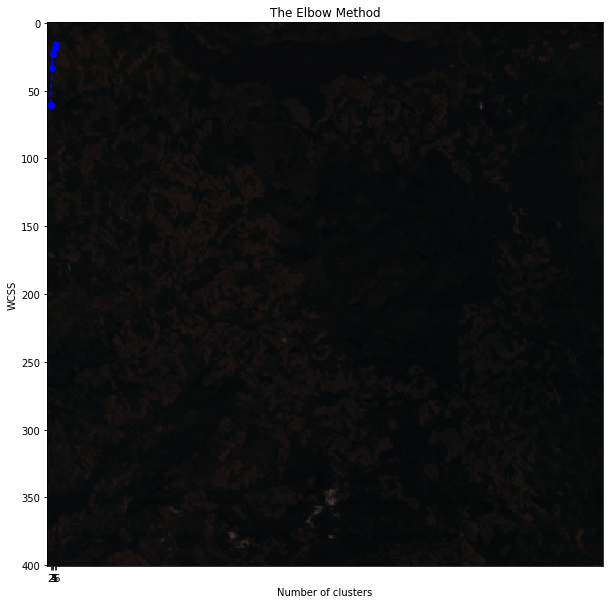

Starting executing the heirarchical clustering
Going to run the heirarchical clustering


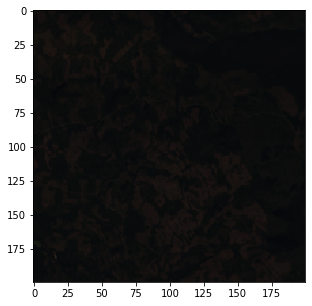

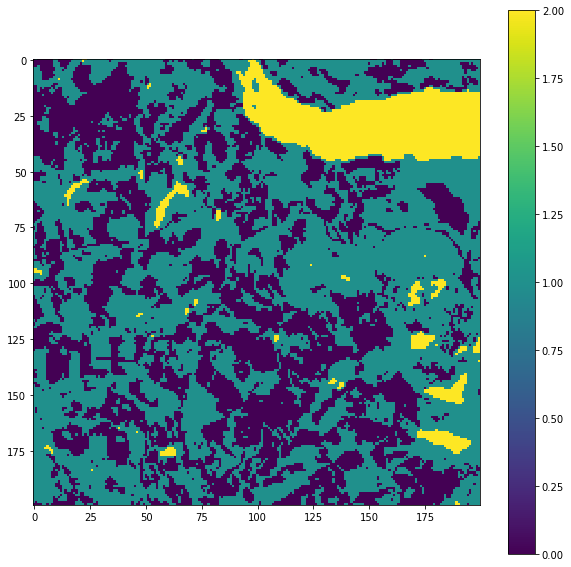

Number of clusters found:  None
Labels:  [0 1 0 ... 1 1 1]
Number of leaves:  40000
Number of connected components:  1
X start reached  200
X end reached  400
Number of rows in the cropped image:  200
Number of columns in the cropped image:  200
Number of bands in the cropped image:  12
(40000, 12)


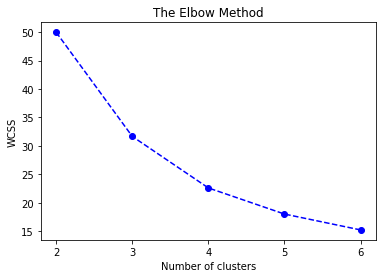

Starting executing the heirarchical clustering
Going to run the heirarchical clustering


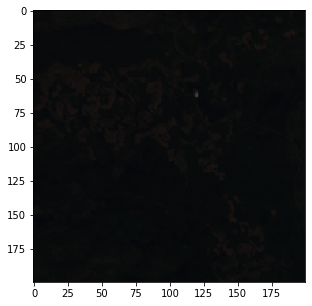

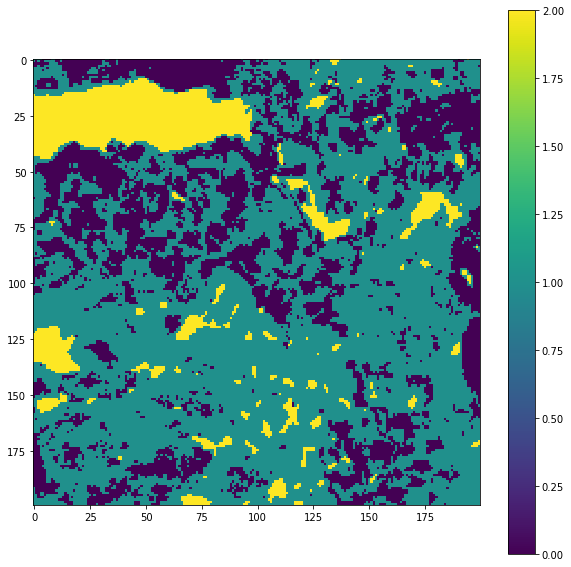

Number of clusters found:  None
Labels:  [1 1 1 ... 1 1 1]
Number of leaves:  40000
Number of connected components:  1
Y star reached  200
Y end reached  400
X start reached  0
X end reached  200
Number of rows in the cropped image:  200
Number of columns in the cropped image:  200
Number of bands in the cropped image:  12
(40000, 12)


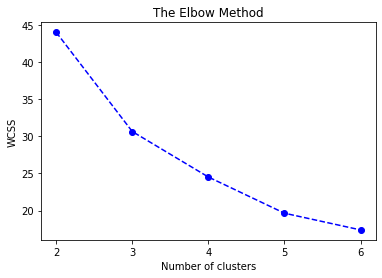

Starting executing the heirarchical clustering
Going to run the heirarchical clustering


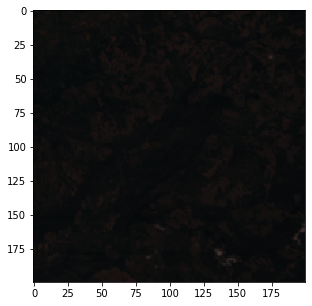

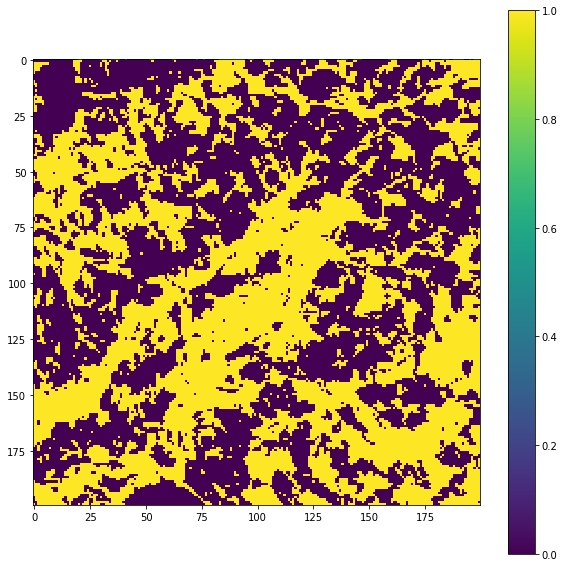

Number of clusters found:  None
Labels:  [0 0 0 ... 1 1 1]
Number of leaves:  40000
Number of connected components:  1
X start reached  200
X end reached  400
Number of rows in the cropped image:  200
Number of columns in the cropped image:  200
Number of bands in the cropped image:  12
(40000, 12)


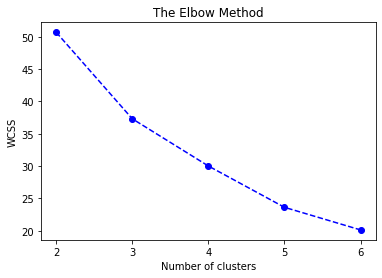

Starting executing the heirarchical clustering
Going to run the heirarchical clustering


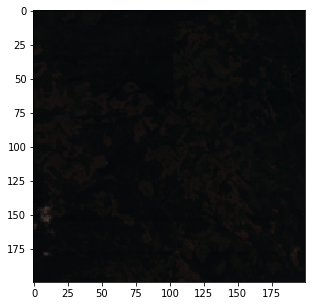

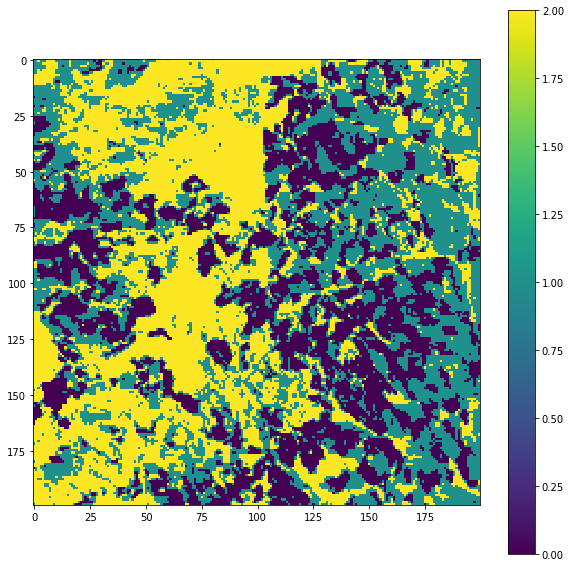

Number of clusters found:  None
Labels:  [1 2 1 ... 1 1 1]
Number of leaves:  40000
Number of connected components:  1
Total number of different clustered cropped images we got:  4
Starting creating the color map
data length:  4
Cropped_Images shape:    (200, 200, 12)
Hello
0  hello
Total number of indexes or values in given cluster:  15023
1  hello
Total number of indexes or values in given cluster:  21624
2  hello
Total number of indexes or values in given cluster:  3353
Hello
0  hello
Total number of indexes or values in given cluster:  11286
1  hello
Total number of indexes or values in given cluster:  24716
2  hello
Total number of indexes or values in given cluster:  3998
Hello
0  hello
Total number of indexes or values in given cluster:  20460
1  hello
Total number of indexes or values in given cluster:  19540
Hello
0  hello
Total number of indexes or values in given cluster:  10731
1  hello
Total number of indexes or values in given cluster:  14818
2  hello
Total number of inde

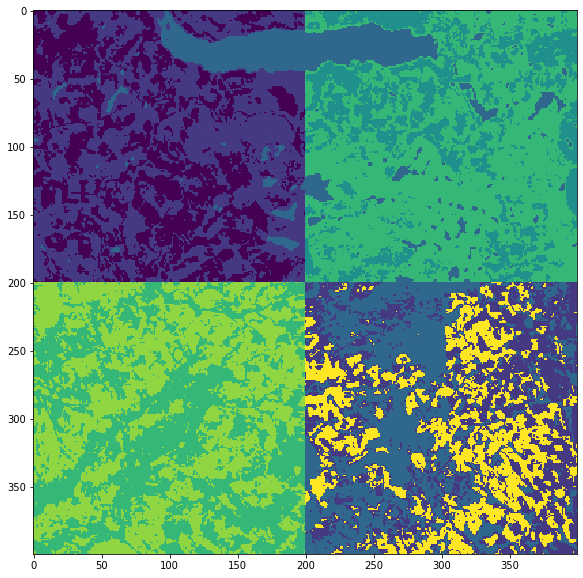

In [0]:
 #Compare Hierarchical Clustering Results to the truth data, (the given data in the provided raw image is not normalized)
  """
@author: gagandeepbajwa
    based on sattelite-clustering.py by @franama

""" 
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_extraction.image import grid_to_graph
import cv2
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

#colab imorts
from google.colab import drive
from google.colab.patches import cv2_imshow # because cv2 doesnot work in colab

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

#defining gloab data
global_data=[]

broadLeaf_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/BROADLEAF_SP.tif_project_4x.bin_sub.bin"
ccutbl_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CCUTBL_SP.tif_project_4x.bin_sub.bin"
conifer_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CONIFER_SP.tif_project_4x.bin_sub.bin"
exposed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/EXPOSED_SP.tif_project_4x.bin_sub.bin"
herb_grass_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/HERB_GRAS_SP.tif_project_4x.bin_sub.bin"
mixed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/MIXED_SP.tif_project_4x.bin_sub.bin"
rivers_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/RiversSP.tif_project_4x.bin_sub.bin"
shrub_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/SHRUB_SP.tif_project_4x.bin_sub.bin"
water_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/WATERSP.tif_project_4x.bin_sub.bin"
vri_s2_objid2="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s2_objid2.tif_project_4x.bin_sub.bin"
vri_s2_objid3="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s3_objid2.tif_project_4x.bin_sub.bin"

'''
Function Description: Running heirarchical Clustering on the image

'''
def hierarchical_clustering(image, img, desired_clusters):

    print('Starting executing the heirarchical clustering')
    
    # set parameters for clustering
    n_clusters_desired = desired_clusters # need to experiment with this
    print('Going to run the heirarchical clustering')
    hierarchical_clustering = AgglomerativeClustering(n_clusters = None, distance_threshold=5, linkage='ward') #distance_threshold
    #hierarchical_clustering = AgglomerativeClustering(n_clusters = desired_clusters, linkage='ward') #distance_threshold

    # do the clustering
    hierarchical_clustering.fit(image)

    # extract cluster labels and reshape for plotting
    X_cluster = hierarchical_clustering.labels_
    X_cluster = X_cluster.reshape(img[:, :, 0].shape)

    plt.figure(figsize=(10, 10))
    #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    # Create the colormap
    #cm = LinearSegmentedColormap.from_list("my map", colors, N=10)
    plt.imshow(X_cluster) #, cmap=cm)
    plt.colorbar()
    plt.show()

    # clr_cropped_img = np.zeros((img.shape[0], img.shape[1], 3))
    # for b in range(1,4):
    #     clr_cropped_img[:, :, 3-b] = img[:, :, b]

   # plt.figure(figsize=(10,10))
    
    # plt.imshow(clr_cropped_img)

    # returning the following values: number of clusters, lables, number of trees in the hierarchical tree
    #           number of connected components in the graph
    return hierarchical_clustering.n_clusters, hierarchical_clustering.labels_, hierarchical_clustering.n_leaves_, hierarchical_clustering.n_connected_components_



'''
Function Description: Running the DBSCAN
'''
def dbscan_clustering(image, img):
    
    dbscan_clustering = DBSCAN(eps=0.5, min_samples=10, algorithm= 'ball_tree')

    dbscan_clustering.fit(image)

    X_cluster = dbscan_clustering.labels_
    X_cluster = X_cluster.reshape(img[:, :, 0].shape)

    plt.figure(figsize=(20, 20))
    #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    # Create the colormap
    #cm = LinearSegmentedColormap.from_list("my map", colors, N=10)
    plt.imshow(X_cluster) #, cmap=cm)
    plt.colorbar()
    plt.show()


'''
Function Description: Creating the colormap of the whole image by providing the cropped clustered data
'''    
def create_color_map(data, originalImageData, img, cropped_size):
    print('Starting creating the color map')

    #initializing the final_labels
    final_labels=data[0][1][:cropped_size]
    final_labels_ = [] #numpy array that will store final labels
    img_ = img
    data_ = data
    originalImageData_ = originalImageData.copy()
    cropped_size_ = cropped_size

    #Run Algorithm to merge the clusters
    merging_algorithm(img_, originalImageData_, final_labels_, data_)
  
  

'''
Function Description: Run the merging algorithm 
'''
def merging_algorithm(image, cropped_images, final_labels, data, random_sampling=False, centroids=False):
    clusters=[]

    print("data length: ", len(data))
    
    print('Cropped_Images shape:   ', cropped_images[0].shape)

    cluster_nos =[]
    indexes_for_clusters=[]
    labels_in_cropped =[] #storing labels in the cropped image shape, so it will be easy to join them at the end

    #comparing the cluster objects and deciding whether two cluster objects need to be considered one or not
    for r in range(len(data)): # go through all the elements stored in the data object
        labels = data[r][1] # getting labels for individual cropped images
        #reshaping the labels into the cropped image shape
        labels_cr = labels.reshape(cropped_images[0][ :, :, 0].shape)
        #labels_cr = labels #just here for testing
        labels_in_cropped.append(labels_cr)
        cluster_nos.append(max(labels)) # appending the maximum number in labels means number of clusters in that cropped_image
        print('Hello')
        for k in range(max(labels)+1): # go through each of the cluster
            np_labels = np.array(labels_cr)
            indexes_f = np.where(np_labels==k) # get all the indexes of the occurrence of specific element in the numpy array
            i_cluster_values_ = []
            indexes = np.array((indexes_f[0], indexes_f[1])).T
            print(k, ' hello')
            print('Total number of indexes or values in given cluster: ',len(indexes))
            
            for ind in range(len(indexes)):
                i_cluster_values_.append(cropped_images[r][indexes[ind][0], indexes[ind][1]])
               
            i_cluster_values = np.array(i_cluster_values_) #.reshape(cropped_images[0].shape[0]*cropped_images[0].shape[1], cropped_images[0].shape[2])
            #print('cluster_vlaue we got: ', i_cluster_values.shape)
            clusters.append([i_cluster_values, 0]) # append all the cluster objects to the clusters list
            indexes_for_clusters.append([indexes, r, k]) # appending all the clusters's index and indexes of all the objects in that cluster we got from running heirarchical clustering on a cropped image

    #printing total number of cluster objects we found
    print("Total Number of clusters found: ",len(clusters))
    print("Maximum number of clusters found in the cropped images: ", max(cluster_nos))
    print(len(clusters[0][0]))

    #labels numbers user
    lnu = []

    #compared
    comparedp = 0

    magic_number = []

    for i in range(len(clusters)):
        magic_number.append(i)
    
    #starting comparing the clusters
    for a in range(len(clusters)):
        comparedp = 0 # re-initilaizae it toi zero for each cluster a 
        for b in range(a,len(clusters)):
            if(a!=b and clusters[a][1] != 1 and clusters[b][1]!=1): # processed with the comparison only if both clusters are different
                cluster_a = clusters[a][0]
                cluster_b = clusters[b][0]
                a_b = np.concatenate((cluster_a, cluster_b))
                #now run the heirarchical clustering
                hierarchical_clustering = AgglomerativeClustering(n_clusters = None, distance_threshold=5 , linkage='ward')  #distance threshold has been changed from 25 to 30, need to experiment with it

                # do the clustering
                hierarchical_clustering.fit(a_b)
                        
                # extract cluster labels and reshape for plotting
                cluster = hierarchical_clustering.labels_
                #printing total number of clusters found
                #print(max(cluster))
                percentages=[]
                for l in range(max(cluster)+1):
                    count = list(cluster).count(l)
                    total_length = cluster.shape[0]
                    percentages.append((count/total_length)*100)
                    # print('Number of data points that get cluster number ',l, ' is: ', count)
                    # print('Its percentage in the total number of data points: ', (count/total_length)*100)
                    # print('How many percentage of cluster b: ', b,' are ', (count/cluster_b.shape[0])*100)


                if(max(cluster)>=1):
                # if(min(percentages)>):
                    print('Move on, they are different clusters', a, 'and ', b)

                    #printing comparison results in detail if both the cluster come out to be different
                   
                    
                    #update the label numbers, because their label number may be acquired by some other clusters while merging, do this only when your cluster is unique
                    if(b==magic_number[len(magic_number)-1] and comparedp==0):
                        print('Cluster Number: ',a,' came out to be a lonely cluster')
                    
                        cropped_imgan = indexes_for_clusters[a][1]
                        indexes_vtca = indexes_for_clusters[a][0]
                        values1=[]
                        for values in indexes_vtca:
                            if(len(lnu)==0):
                                values1.append(0)
                            
                            else:
                                values1.append(lnu[len(lnu)-1]+1)
                        
                        indlablesa = indexes_vtca
                        for inla in range(len(indexes_vtca)):
                            labels_in_cropped[cropped_imgan][indlablesa[inla][0], indlablesa[inla][1]] = values1[inla]
                        
                        if(len(lnu)==0):
                          lnu.append(0)
                        
                        else:
                          lnu.append(lnu[len(lnu)-1]+1) # this label number is already used
                          print('List of clusters we have ',lnu)
                      
                                        
                else:
                    #increment the compared positive
                    comparedp+=1
                    magic_number.remove(b) #add removed clusters to the magic_number list
                    print('Magic Number: ', magic_number) #informative print
                    clusters[b][1]= 1 #mark the cluster as done because we dont need to compare it with other clusters again
                    print('Something is here to think about', a, ' and ', b)
                    indexes_vtca = indexes_for_clusters[a][0] # indexes where values need to be changed
                    cropped_imgan = indexes_for_clusters[a][1]

                    indexes_vtcb = indexes_for_clusters[b][0] # indexes where values need to be changed
                    cropped_imgbn = indexes_for_clusters[b][1]
                
                    
                    values2a=[]
                    for values in indexes_vtca:
                        if(len(lnu)==0):
                            values2a.append(0)
                        
                        else:
                            if(comparedp>1):
                                values2a.append(lnu[len(lnu)-1])
                            
                            else:
                                values2a.append(lnu[len(lnu)-1]+1)
                        
                    
                    values2b=[]
                    for values in indexes_vtcb:
                        if(len(lnu)==0):
                            values2b.append(0)
                        
                        else:
                            if(comparedp>1):
                                values2b.append(lnu[len(lnu)-1])
                            
                            else:
                                values2b.append(lnu[len(lnu)-1]+1)
                    
                    indlablesa = indexes_vtca
                    indlablesb = indexes_vtcb
                    for inla in range(len(indexes_vtca)):
                        labels_in_cropped[cropped_imgan][indlablesa[inla][0], indlablesa[inla][1]] = values2a[inla]
                    
                    for inlb in range(len(indexes_vtcb)):
                        labels_in_cropped[cropped_imgbn][indlablesb[inlb][0], indlablesb[inlb][1]] = values2b[inlb]
            
                    if(comparedp==1):
                        lnu.append(values2a[0]) # this label number is already used
                    
                    print(lnu)
            
            #if the cluster is the last one
            else:
              if(a==magic_number[len(magic_number)-1] and comparedp==0):
                        print('Cluster Number: ',a,' came out to be a lonely cluster')
                    
                        cropped_imgan = indexes_for_clusters[a][1]
                        indexes_vtca = indexes_for_clusters[a][0]
                        values1=[]
                        for values in indexes_vtca:
                            if(len(lnu)==0):
                                values1.append(0)
                            
                            else:
                                values1.append(lnu[len(lnu)-1]+1)
                        
                        indlablesa = indexes_vtca
                        for inla in range(len(indexes_vtca)):
                            labels_in_cropped[cropped_imgan][indlablesa[inla][0], indlablesa[inla][1]] = values1[inla]
                        
                        
                        lnu.append(lnu[len(lnu)-1]+1)
                        break
              
    #       plt.figure(figsize=(7, 7))
    #       #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    #       # Create the colormap
    #       #cm = LinearSegmentedColormap.from_list("my map", colors, N=10)
    #       plt.imshow(X_cluster) #, cmap=cm)
    #       plt.colorbar()
    #       plt.show()
                

    #join the cropped labels
    print('------------------------\nStarting Joining the Cropped Images\n----------------- ')
    #cropped Size
    cropped_size = 200

    csm = 0
    mastern = 0

    print('labels_in_cropped size: ', len(labels_in_cropped))


    print('Number of clusters found in the result image: ', len(lnu))


    for master in range(2):
    #     print('Mastern Value is: ', mastern)
        #after the new row is started initialize csm back to 0
        csm=0
        for x in range(cropped_size):
    #         print('x is: ', x)       
            for y in range(2):
    #           print('csm value is: ', csm)
    #           print("csm plus cropped size: ", csm + cropped_size)   
                #showing the cropped image with the new labels
    #           plt.figure(figsize=(5,5))
    #           plt.imshow(labels_in_cropped[y+mastern].reshape(196,196))

               
                #doing the appending operations
                data_= labels_in_cropped[y+mastern].reshape(cropped_size*cropped_size)  
                final_labels = np.concatenate((final_labels, data_[csm:csm+cropped_size]))
                #size of the final labels
        #           print(final_labels.shape)
                
                if(y==1):# when y i s6 change the csm to add 196 from each image
                    csm=csm+cropped_size
                
            if(x==199):
                    #changing the master number plus 7     
                    mastern = mastern + 2  
    

    print(image.shape)
    print(final_labels.shape)  
    
    #reshaping the final labels
    rfl = final_labels.reshape(400,400)

    print(rfl.shape)  
    
    print('Number of clusters found in the final image', max(final_labels)+1)

    # allocate memory to reshape image
    img_colored = np.zeros((400,  # number of rows
                    400,  # number of cols
                    3),  # number of bands
                    gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType)) # data type code
    

    # for b in range(1,4):
    #     img_colored[:, :, 3-b] = img[0:392, 0:392, b]


    # plt.figure(figsize=(10, 10))
    # plt.imshow(img_colored) #show the colored image for the testing image of size 392, 392

    #plt.savefig('/content/gdrive/My Drive/cropped_img.png')
    # drive.download('cropped_image.png')
    
    #shwing the final image
    plt.figure(figsize=(10, 10))
    plt.imshow(rfl)
    #plt.colorbar() 
    #plt.savefig('/content/gdrive/My Drive/color_map.png')



'''
Function Description: Splitting the main image
'''
def image_splitter(image, number):
    
    print('Starting the image splitting')
    #showing the original image
    #img=cv2.imread(image)
    img= image;
    #cv2.imshow('output', img) does not work witj colab
   # cv2_imshow(img)
    #cv2.waitKey(0)

    #Getting the size of the image
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    #Size per cropped image
    #cropped_size = int(img.shape[0]/number) # as we have square images, this need to be changed according to the image dimensions

    cropped_size = 200
    # intitializing the array to store all the required information
    data = [];
    
    #initializing the array that will store numpy array objects of the cropped images
    original_data=[]

    #crop starter
    cs = 0
    cj_cs=0
    cj=0
    for i in range(2):
      
        cj=cj_cs
        cj_cs=cj_cs+cropped_size
        
        print('Y star reached ' ,cj)
        
        print('Y end reached ',cj_cs)
        
        #starting again from the left most
        cs=0
        
        for j in range(2):
          
            print('X start reached ', cs)
            
            print('X end reached ', cs+cropped_size)
          
            #cropping down the image
            crop_img = img[ cj:cj_cs,cs:cs+cropped_size ]

            #informative
            print('Number of rows in the cropped image: ',crop_img.shape[0])
            print('Number of columns in the cropped image: ', crop_img.shape[1])
            print('Number of bands in the cropped image: ', crop_img.shape[2])


            #initialize an empty numpy array of cropped image size
            np_crop_img =  np.zeros((crop_img.shape[0],  # number of rows
                            crop_img.shape[1],  # number of cols
                            crop_img.shape[2])  # number of bands
                            )


            #store the image data in the numpy array for reshaping
            for b in range(crop_img.shape[2]):
                np_crop_img[:,:,b] = crop_img[:,:,b]   

            #convert the image to single to numpy array
            new_crop_img_shape = (np_crop_img.shape[0]*np_crop_img.shape[1], np_crop_img.shape[2])
            crop_img_X = np_crop_img[:,:,:np_crop_img.shape[2]].reshape(new_crop_img_shape)
            print(crop_img_X.shape)
                        
            #before running heirarchical clustering find the number of appropriate clusters in the cropped image
            ap_clusters_possible=elbow_method(crop_img_X, 7) #7 is the maximum number of clusters found in the whole image using elbow method

            # showing the cropped image
            #before showing the cropped image we only need 3 bands
            clr_cropped_img = np.zeros((crop_img.shape[0], crop_img.shape[1], 3))
            for b in range(1,4):
              clr_cropped_img[:, :, 3-b] = crop_img[:, :, b]
            
            #display the image
            plt.figure(figsize=(5, 5))
            plt.imshow(clr_cropped_img)
        
            #cv2_imshow(crop_img)

            #Runninng hierarchical clustering on the cropped image and  receiving the 
            (n_cluster, lables, n_leaves, n_connected_components )=hierarchical_clustering(crop_img_X, crop_img,7 )

            #pushing the cropped image numpy array to the image_data array
            original_data.append(crop_img)

            #pushing the data to the data array for further interpretation
            data.append((n_cluster, lables, n_leaves, n_connected_components ))

            print('Number of clusters found: ', n_cluster)
            print('Labels: ', lables)
            print('Number of leaves: ', n_leaves)
            print('Number of connected components: ', n_connected_components )

            #increment the crop starter
            cs=cs+cropped_size

            #show the cropped image
            #cv2.imshow("its cropped",crop_img)
            #cv2.waitKey(0)
    

    #printing totla number of clustered cities we get
    print('Total number of different clustered cropped images we got: ', len(data))
    
    #create the color map
    create_color_map(data, original_data, img, cropped_size)




"""
Plots number of clusters vs. within cluster sum of squares
(which we aim to minimize)
"""
def elbow_method(image_2d, max_k):
    wcss = []
    for i in range(2, max_k):
        kmeans = KMeans(n_clusters=i, init='k-means++',
                        random_state=42)
        kmeans.fit(image_2d)
        wcss.append(kmeans.inertia_)

    x = [i for i in range(2, max_k)]
    plt.plot(x, wcss, '--bo')
    plt.xticks(x, x)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    #after plotting the elbow find the corner point
    



'''
Function Description: Display an image
'''



'''
Function Description: Main Function
'''

if __name__ == "__main__":
    

    drive.mount('/content/gdrive')
    # parse command line arg
    try:
        #!cp '/content/gdrive/My Drive/2019-10-2-111855.png' image
        image = '/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/S2A.bin_4x.bin_sub.bin'   #trying it with the 12 band original image
        #image = '/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/BROADLEAF_SP.tif_project_4x.bin_sub.bin'
        
    # catch no file given
    except IndexError:
        print("Must provide a filename")
        sys.exit(0)

    #with the same image create multiple images
    
    # Read in raster image
    img_ds = gdal.Open(image, gdal.GA_ReadOnly)

    # allocate memory to reshape image
    img = np.zeros((img_ds.RasterYSize,  # number of rows
                    img_ds.RasterXSize,  # number of cols
                    img_ds.RasterCount),  # number of bands
                    gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType)) # data type code

    # reshape the image band by band
    for b in range(img.shape[2]):
        print("reading band", b + 1, "of", img.shape[2])
        print('Band Type: ', img_ds.GetRasterBand(b+1).DataType)
        img[:, :, b] = normalize(img_ds.GetRasterBand(b + 1).ReadAsArray(), norm='l2', copy=True)  # normalizing the values for each band using sklearn.preprocessing.normalize, where available norm types are 'l1', 'l2', and 'max', by default the norm is 'l2s'
        # img[:,:, b] = StandardScaler(copy=True, with_mean=True,
        #                     with_std=True).fit_transform(img_ds.GetRasterBand(b + 1).ReadAsArray())
        print('Max value in band', b,' is ', np.amax(img[:,:,b]))


    #Printing the shape of the image
    print(img.shape[0]*img.shape[1])
    print(img.shape[0])
    print(img.shape[1])
    print('Image Raster Count: ', img.shape[2])

    # normalize the data
    # image_ = StandardScaler(copy=True, with_mean=True,
    #                          with_std=True).fit_transform(img)
    #Downsampling the image before reshaping
   #img = img[::2, ::2] + img[1::2, ::2] + img[::2, 1::2] + img[1::2, 1::2]

    #new_img = img[0:400,0:400]  #get sub images out of the original images

    # reshape image again to match expected format for scikit-learn
    new_shape = (img.shape[0] * img.shape[1], img.shape[2])
    X = img[:, :, :img.shape[2]].reshape(new_shape)
    print (X.shape[0])


    clr_cropped_img = np.zeros((img.shape[0], img.shape[1], 3))
    for b in range(1,4):
        clr_cropped_img[:, :, 3-b] = img[:, :, b]

    plt.figure(figsize=(10,10))
    
    plt.imshow(clr_cropped_img)


    

    #running the hierarchical clustering
    #hierarchical_clustering(X, new_img, 7)

    #runnig the DBSCAN
    #dbscan_clustering(X, img)

    #running image splitting
    #image_splitter(image, 7)
    image_splitter(img,7)
    #image_splitter(new_img, 7)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Reading Raster Image
Creating input matrix
Original Shape (401, 410, 3)
New Shape: (164410, 3)
Running K Means 
K = 7
Fitting K Means
Creating clusters
Clusters created
Time: 3.417492389678955
Creating Color Map
Saving color map image
Comparing with cluster number:  0
Reading Raster Image
Creating input matrix


RuntimeError: ignored

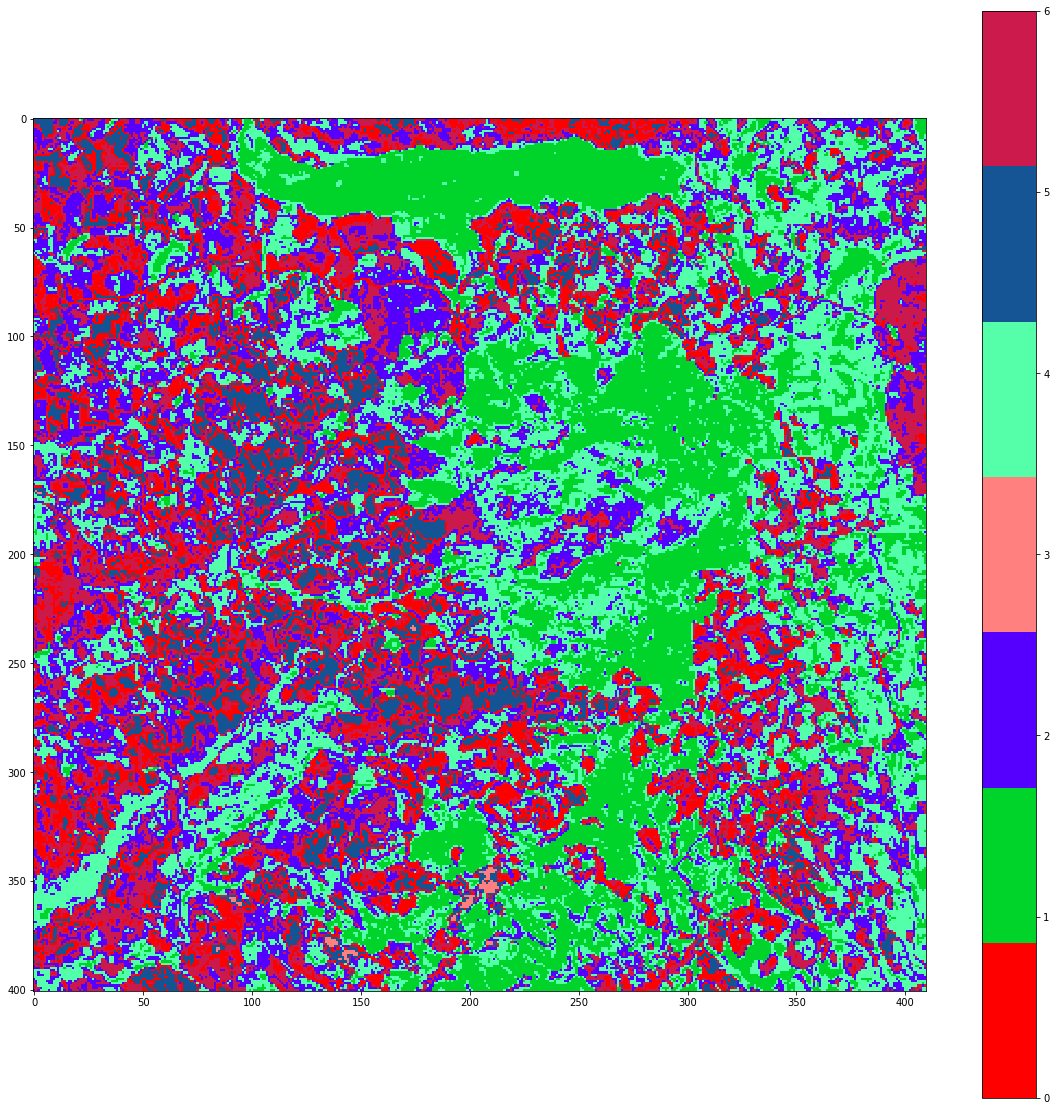

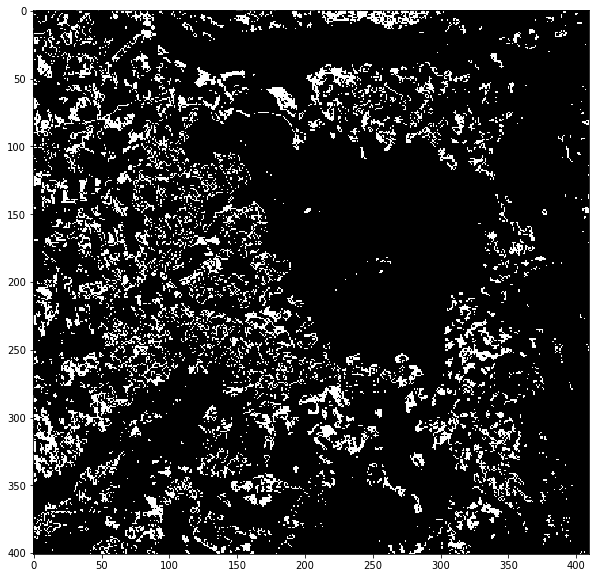

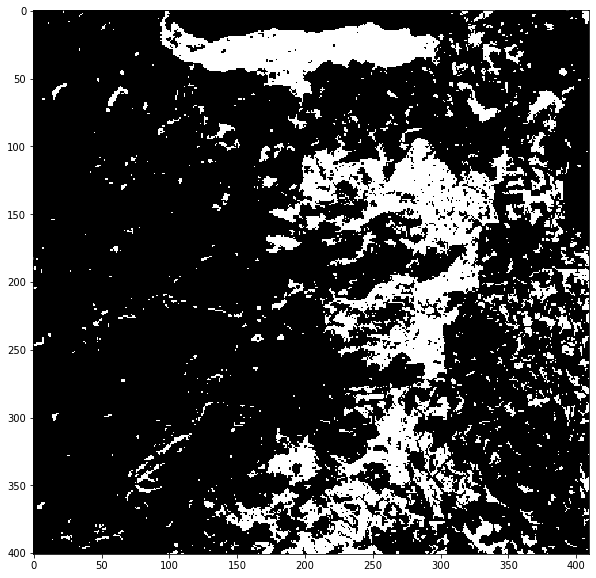

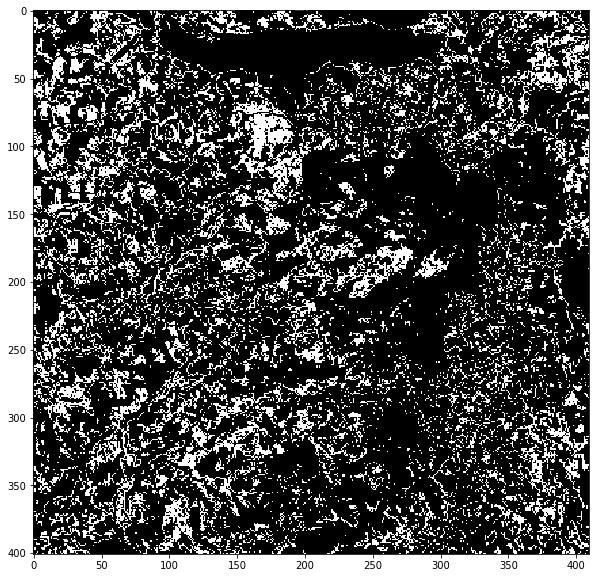

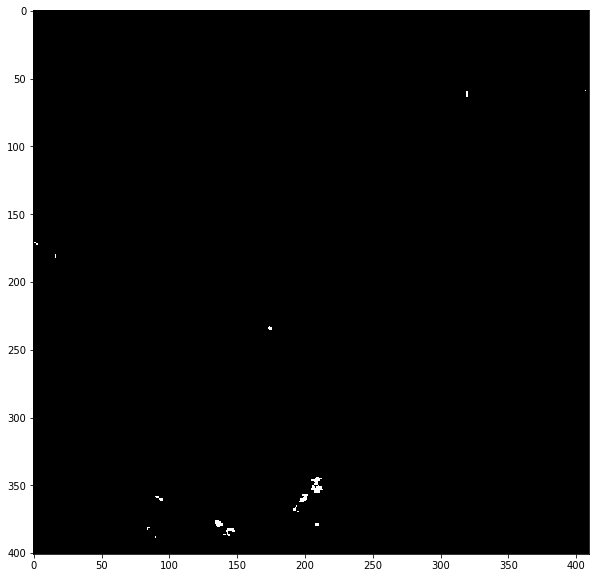

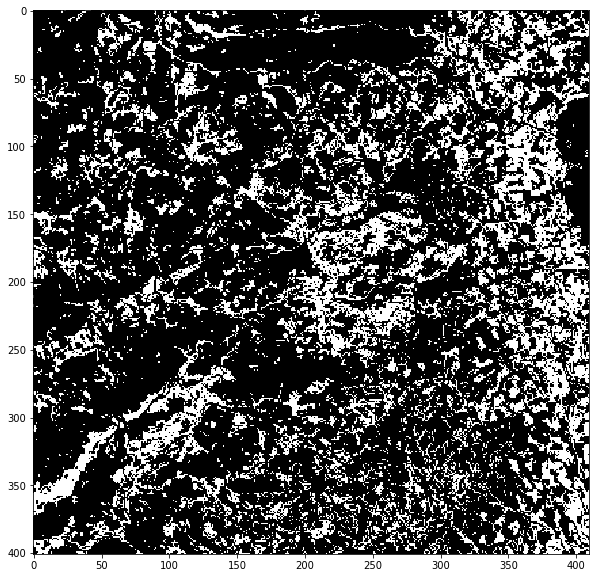

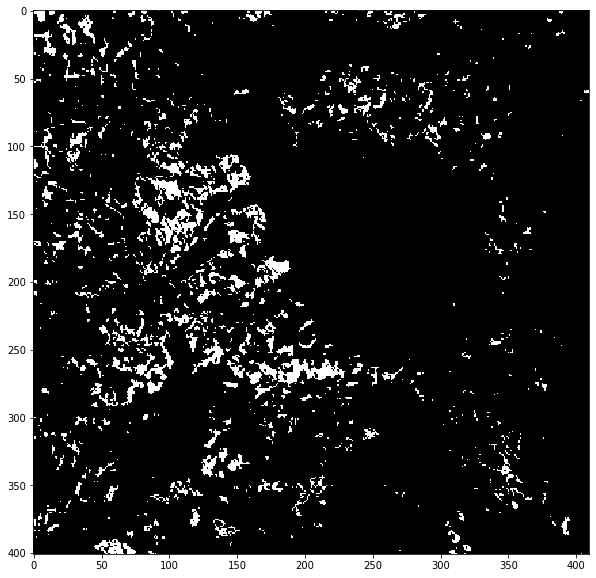

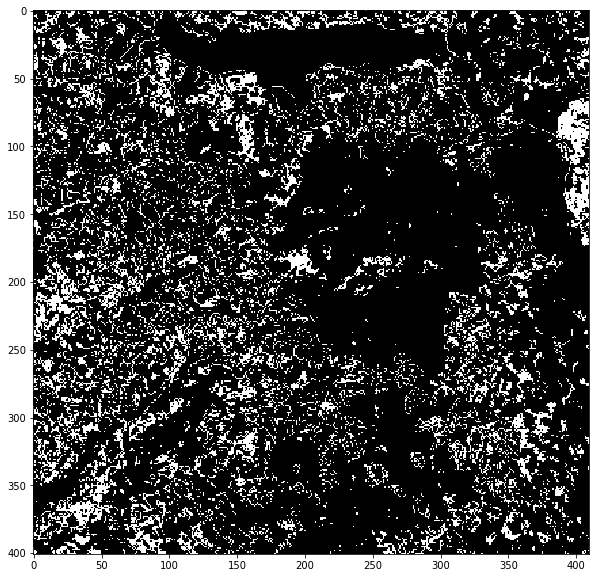

In [0]:

#comparing k-means clustering with the truth data

"""
    @author: gagandeepbajwa
    based on kmeans_clustering_cli.py by @franama

"""
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
from sklearn.cluster import KMeans
import numpy as np
from osgeo import gdal, gdal_array
import sys
import math
import time

#colab imorts
from google.colab import drive
from google.colab.patches import cv2_imshow # because cv2 doesnot work in colab

gdal.UseExceptions()
gdal.AllRegister()


# mounting the google drive
drive.mount('/content/gdrive')


rawImagePath = "/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/"
colorMapImagePath = "/content/gdrive/My Drive/Color_Maps/"
imageName = "S2A.bin_4x.bin_sub"
imageExtension = ".bin"

image = rawImagePath + imageName + imageExtension

#Truth Data Layers
broadLeaf_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/BROADLEAF_SP.tif_project_4x.bin_sub.bin"
ccutbl_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CCUTBL_SP.tif_project_4x.bin_sub.bin"
conifer_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CONIFER_SP.tif_project_4x.bin_sub.bin"
exposed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/EXPOSED_SP.tif_project_4x.bin_sub.bin"
herb_grass_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/HERB_GRAS_SP.tif_project_4x.bin_sub.bin"
mixed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/MIXED_SP.tif_project_4x.bin_sub.bin"
rivers_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/RiversSP.tif_project_4x.bin_sub.bin"
shrub_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/SHRUB_SP.tif_project_4x.bin_sub.bin"
water_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/WATERSP.tif_project_4x.bin_sub.bin"
vri_s2_objid2="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s2_objid2.tif_project_4x.bin_sub.bin"
vri_s2_objid3="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s3_objid2.tif_project_4x.bin_sub.bin"

save_colormap_path="/content/gdrive/My Drive/K_Means_Color_Maps/K14/"

# Params
K = 7
MAX_K = 20
init = 'k-means++'
n_init = 10
# number of processors to use (default 1, -1 uses all processors)
n_jobs = -1


#list containing the all the layers created from k-means
individual_layers=[]

def showImage(filepath):
    image = cv2.imread(filepath)
    plt.show(image)
    plt.show()


def readRasterImage(image):
    print("Reading Raster Image")
    image_ds = gdal.Open(image, gdal.GA_ReadOnly)
    return image_ds


def getInputMatrix(image_ds):
    image = np.zeros((image_ds.RasterYSize, image_ds.RasterXSize, image_ds.RasterCount),
                     gdal_array.GDALTypeCodeToNumericTypeCode(image_ds.GetRasterBand(1).DataType))
    print("Creating input matrix")
    for band in range(image.shape[2]):
        image[:, :, band] = image_ds.GetRasterBand(band + 1).ReadAsArray()

    print('Original Shape', image.shape)
    new_shape = (image.shape[0] * image.shape[1], image.shape[2])
    print("New Shape:", new_shape)
    X = image[:, :, :13].reshape(new_shape)

    return X, image


def runKMeans(K, X, image):
    start = time.time()
    print("Running K Means", "\nK =", K)
    k_means = KMeans(n_clusters=K, init=init, n_init=n_init,
                     n_jobs=n_jobs, verbose=1)
    print("Fitting K Means")
    k_means.fit(X)
    print("Creating clusters")
    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(image[:, :, 0].shape)
    print("Clusters created")
    stop = time.time()
    totalProcessTime = stop - start
    print("Time: " + str(totalProcessTime))
    return X_cluster


def createColorMap(X_cluster, K):
    plt.figure(figsize=(20, 20))
    colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0),
              (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    print("Creating Color Map")
    cm = LinearSegmentedColormap.from_list("Map", colors, N=K)
    plt.imshow(X_cluster, cmap=cm)
    plt.colorbar()
    plt.show
    print("Saving color map image")
    # plt.imsave(save_colormap_path + imageName +
    #            "k_7_colormap.png",  X_cluster, cmap=cm)


def elbow_method(image_2d, max_k):
    wcss = []
    for i in range(2, max_k):
        kmeans = KMeans(n_clusters=i, init='k-means++',
                        random_state=42)
        kmeans.fit(image_2d)
        wcss.append(kmeans.inertia_)

    x = [i for i in range(2, max_k)]
    plt.plot(x, wcss, '--bo')
    plt.xticks(x, x)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

'''
Function Description: Create an Individual Layer from the generated color map
'''
def create_individual_layer(c_no, colormap):
   colormap_ext =  np.zeros((colormap.shape[0], colormap.shape[1]))
   colormap_ext[:,:] = colormap[:,:]
   for index_x in range(colormap.shape[0]):
     for index_y in range(colormap.shape[1]):
       if(colormap_ext[index_x, index_y]==c_no):
         colormap_ext[index_x, index_y]=1
       
       else:
         colormap_ext[index_x, index_y]=0
   colors = [(0,0,0), (1,1,1)]
   cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
   plt.figure(figsize=(10, 10))
   plt.imshow(colormap_ext, cmap=cm)
  #  plt.imsave(save_colormap_path+str(c_no)+".png", colormap_ext, cmap=cm )
   individual_layers.append(colormap_ext) # append individual layer created to the list, so that it can be used later to compare with the truth data

'''
Function Description: Compare classes created by unsupervised method to the truth data
'''
def compare(layer_type, cluster_n):
  l_ds = readRasterImage(layer_type)
  X, l_img = getInputMatrix(l_ds)
  print(X.shape)
  print(X[0,0])
  water_X=np.zeros((l_img.shape[0], l_img.shape[1]))
  water_X = X.reshape(l_img[:,:,0].shape) #truth_data layer
  layer_k = np.zeros((l_img.shape[0], l_img.shape[1]))
  layer_k = individual_layers[cluster_n] #layer generated from the k_means
  print('Unique values in the given truth layer: ',np.unique(water_X))
  for index_x in range(water_X.shape[0]):
    for index_y in range(water_X.shape[1]):
      if(water_X[index_x,index_y]==1.130000e+03):
        water_X[index_x,index_y]=0
      
      else:
        water_X[index_x,index_y]=1
  colors = [(0,0,0), (1,1,1)]
  cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
  plt.figure(figsize=(10, 10))
  plt.imshow(water_X, cmap=cm)

  #get the stats
  stat(water_X, layer_k)

   

'''
Function Description : Return Stats over the layer generated from K-Means to the the truth data layer 
'''
def stat(truth_layer, generated_layer):
  #counters for the score
  true_positive=0
  true_negative=0
  false_negative=0
  false_positive=0

  for index_x in range(truth_layer.shape[0]):
    for index_y in range(truth_layer.shape[1]):
      if(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==1):
        true_positive+=1
      elif(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==0):
        false_negative+=1
      elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==1):
        false_positive+=1
      elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==0):
        true_negative+=1

  #compute the stats
  precision = true_positive/(true_positive+false_positive)
  print('Precision is:', precision*100, '%')

  recall = true_positive/(true_positive +false_negative)
  print('Recall is: ', recall*100, '%')

  iou = (true_positive + true_negative)/(true_positive + true_negative + false_negative + false_positive)
  print('Accuracy(IOU) is: ', iou*100, '%')

  print('True_Positive: ',true_positive)
  print('False_Positive: ',false_positive)
  print('True_Negative: ',true_negative)
  print('False_Negative: ',false_negative)





def run():
    showImage(image)
    img_ds = readRasterImage(image)
    X, img = getInputMatrix(img_ds)
    X_cluster = runKMeans(K, X, img)

    # original_img = np.zeros((img.shape[0], img.shape[1], 3))
    # for b in range(2,5):
    #    original_img[:, :, 4-b] = img[:, :, b]

    # plt.figure(figsize=(7,7))
    # plt.imshow(original_img)  
    # plt.imsave(save_colormap_path+'original.png', original_img)

    createColorMap(X_cluster, K)
    #create an individual layers for each of the cluster
    create_individual_layer(0, X_cluster)
    create_individual_layer(1, X_cluster)
    create_individual_layer(2, X_cluster)
    create_individual_layer(3, X_cluster)
    create_individual_layer(4, X_cluster)
    create_individual_layer(5, X_cluster)
    create_individual_layer(6, X_cluster)
    # create_individual_layer(7, X_cluster)
    # create_individual_layer(8, X_cluster)
    # create_individual_layer(9, X_cluster)
    # create_individual_layer(10, X_cluster)
    # create_individual_layer(11, X_cluster)
    # create_individual_layer(12, X_cluster)
    # create_individual_layer(13, X_cluster)
    # create_individual_layer(14, X_cluster)
    # create_individual_layer(15, X_cluster)
    # create_individual_layer(16, X_cluster)
    # create_individual_layer(17, X_cluster)

    # compare(broadLeaf_sp,2 ) #compare the clusters with the truth data water
    #compare(ccutbl_sp,2)
    # compare(conifer_sp,2)
    # compare(exposed_sp,2)
    # compare(herb_grass_sp,2)
    # compare(mixed_sp,2)
    # compare(shrub_sp,2)
    for n in range(K):
      print('Comparing with cluster number: ', n)
      compare(vri_s2_objid2, n)

    print("done")


run()
